# Implementing a Normal Inverse Wishart Distribution in Tensorflow Probability
_Scott Linderman_

_Oct 27, 2021_

---

The normal inverse Wishart (NIW) is a conjugate prior for a multivariate Gaussian with unknown mean and covariance. Specifically, it's a joint distribution on a vector $\mu \in \mathbb{R}^D$ and a positive semi-definite matrix $\Sigma \in \mathbb{R}_{\succeq 0}^{D \times D}$ defined by the following generative model,
\begin{align}
\Sigma &\sim \mathrm{IW}(\nu, \Psi) \\
\mu \mid \Sigma &\sim \mathcal{N}(\mu_0, \kappa^{-1} \Sigma)
\end{align}
The NIW is parameterized by the degrees of freedom $\nu$, a scale matrix $\Psi$, a location $\mu_0$, and a scaling parameter $\kappa$ that I'll call the "mean precision."
Unfortunately, tensorflow probability (TFP) doesn't have a premade NIW distribution and implementing it was a bit of a pain... this notebook shows how I ended up doing it.


## Take 1

TFP's `JointDistribution` objects seem well suited to this problem. I originally hoped implementing an NIW would be as simple as,
```
niw = tfd.JointDistributionNamed(dict(
    Sigma=lambda: tfd.InverseWishart(df, scale), 
    mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(loc, Sigma / mean_precision)
))
```
Unfortunately, TFP doesn't have an `InverseWishart` distribution... 

## Take 2
No problem, we'll just specify the inverse Wishart as a `TransformedDistribution` that wraps the `WishartTriL` distribution... something like,
```
niw = tfd.JointDistributionNamed(dict(
    Sigma=lambda: tfd.TransformedDistribution(
        tfd.WishartTriL(df, np.linalg.cholesky(np.linalg.inv(scale))),
        bijector=tfb.MatrixInverse()), 
    mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(loc, Sigma / mean_precision)
))
```
That leads to the second problem: TFP doesn't have a `MatrixInverse` bijector.

## Take 3
TFP does, however, have a `ChokeskyToInvCholesky` bijector, which maps $L=\mathrm{chol}(X)$ to $L' = \mathrm{chol}(X^{-1})$, and a `CholeskyOuterProduct` bijector that maps a lower triangular matrix $L$ to $LL^\top = X$. So here's the workaround I arrived at: invert the (positive semidefinite) matrix $J$ output by the Wishart distribution by chaining three bijectors:
1. $J \mapsto \mathrm{chol}(J)$ with `Cholesky?`           
2. $\mathrm{chol}(J) \mapsto \mathrm{chol}(J^{-1})$ with `CholeskyToInvCholesky`
2. $\mathrm{chol}(J^{-1}) \mapsto \mathrm{chol}(J^{-1}) \mathrm{chol}(J^{-1})^\top = J^{-1} \equiv \Sigma$ with `CholeskyOuterProduct`.

That would look like,
```
niw = tfd.JointDistributionNamed(dict(
    Sigma=lambda: tfd.TransformedDistribution(
        tfd.WishartTriL(df, np.linalg.cholesky(np.linalg.inv(scale))),
        bijector=tfb.Chain([
            tfb.CholeskyOuterProduct(),
            tfb.CholeskyToInvCholesky(),
            tfb.Cholesky()])), 
    mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(loc, Sigma / mean_precision)
))
```
But TFP doesn't have a `Cholesky` bijector...

## Final Take
Thankfully, the Cholesky bijector is just the inverse of the `CholeskyOuterProduct` bijector, and we can use `tfb.Invert(tfb.CholeskyOuterProduct())` to get it.

The code below puts all of this together. I'm sure there are other implementations. For example, the TFP [Bayesian GMM example](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb) defines a new multivariate normal distribution parameterized by the square root of the inverse covariance (aka precision) matrix. That's probably a bit more efficient since it doesn't have so many conversions to/from Cholesky decompositions. Personally, I prefer the approach below because it outputs a distribution on $(\mu, \Sigma)$, as the NIW is typically specified.



In [1]:
import jax.numpy as np
import jax.random as jr
from jax import vmap
from jax.tree_util import tree_map
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from functools import partial

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
class NormalInverseWishart(tfd.JointDistributionNamed):
    def __init__(self, loc, mean_precision, df, scale, **kwargs):
        """
        A normal inverse Wishart (NIW) distribution with

        Args:
            loc:            \mu_0 in math above
            mean_precision: \kappa_0 
            df:             \nu
            scale:          \Psi 

        Returns: 
            A tfp.JointDistribution object.
        """
        # Store hyperparameters. 
        # Note: these should really be private.
        self.loc = loc
        self.mean_precision = mean_precision
        self.df = df
        self.scale = scale
        
        # Convert the inverse Wishart scale to the scale_tril of a Wishart.
        # Note: this could be done more efficiently.
        self.wishart_scale_tril = np.linalg.cholesky(np.linalg.inv(scale))

        super(NormalInverseWishart, self).__init__(dict(
            Sigma=lambda: tfd.TransformedDistribution(
                tfd.WishartTriL(df, scale_tril=self.wishart_scale_tril),
                tfb.Chain([tfb.CholeskyOuterProduct(),                 
                           tfb.CholeskyToInvCholesky(),                
                           tfb.Invert(tfb.CholeskyOuterProduct())
                           ])
                ),
            mu=lambda Sigma: tfd.MultivariateNormalFullCovariance(
                loc, Sigma / mean_precision)
        ))
        
        # Replace the default JointDistributionNamed parameters with the NIW ones
        # because the JointDistributionNamed parameters contain lambda functions,
        # which are not jittable.
        self._parameters = dict(
            loc=loc,
            mean_precision=mean_precision,
            df=df,
            scale=scale)

In [3]:
# Set hyperparameters.
dim = 3
params = dict(
    loc=np.zeros(dim),
    mean_precision=1.0,
    df=dim + 3,
    scale=np.eye(dim)
)

# Make the distribution object and sample it.
niw = NormalInverseWishart(**params)
smpl = niw.sample(seed=jr.PRNGKey(0))
print(smpl)

{'Sigma': DeviceArray([[ 0.21757844, -0.02874628, -0.23173912],
             [-0.02874628,  0.3247632 ,  0.2481404 ],
             [-0.23173912,  0.2481404 ,  0.6052754 ]], dtype=float32), 'mu': DeviceArray([-0.2123678,  0.5344251,  1.2100078], dtype=float32)}


## Double check the log probability
(by comparing to scipy.stats)

In [4]:
def manual_niw_log_prob(mu, Sigma, loc, mean_precision, df, scale):
    """
    Evaluate the NIW log prob using scipy.stats functions
    """
    from scipy.stats import invwishart
    from scipy.stats import multivariate_normal as mvn

    lp = invwishart.logpdf(Sigma, df, scale)
    lp += mvn.logpdf(mu, loc, Sigma / mean_precision)
    return lp

manual_niw_log_prob(**smpl, **params)
assert np.allclose(niw.log_prob(smpl), manual_niw_log_prob(**smpl, **params))

## Plot the log probability density for the 1D case

In the one-dimensional case, the NIW reduces to a normal inverse chi-squared distribution or the normal inverse gamma distribution (one is a repameterization of other) on $(\mu, \sigma^2)$ where $\Sigma = [[\sigma^2]]$. 

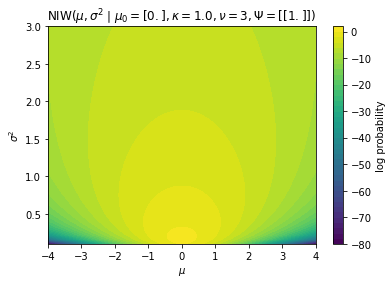

In [5]:
# Make a 1D NIW distribution.
dim = 1
params = dict(
    loc=np.zeros(dim),
    mean_precision=1.0,
    df=dim + 2,
    scale=np.eye(dim)
)
niw = NormalInverseWishart(**params)

# Evaluate the log prob at a grid of points.
n_pts = 50
mus, sigmasqs = np.meshgrid(
    np.linspace(-4, 4, n_pts),
    np.linspace(0.1, 3, n_pts)
)

lps = niw.log_prob(dict(mu=mus.reshape(-1, 1), 
                        Sigma=sigmasqs.reshape(-1, 1, 1)))

# Plot the log density.
plt.contourf(mus, sigmasqs, lps.reshape(n_pts, n_pts), 50)
plt.xlabel("$\\mu$")
plt.ylabel("$\\sigma^2$")
plt.title(r"NIW$(\mu, \sigma^2 \mid \mu_0={loc}, "
          r"\kappa={mean_precision}, \nu={df}, \Psi={scale})$".format(**params))
plt.colorbar(label="log probability")

## Conclusion

Tensorflow probability offers lots of great tools for building probabilistic models. In general, their library of distributions is top notch! One glaring omission is the normal inverse Wishart distribution, an important conjugate prior for multivariate Gaussian models. This notebook implements it as a `JointDistribution` and, along the way, introduces lots of cool `Bijector`'s for converting Wishart samples into inverse Wishart samples. 

In the next post, we'll extend this NIW distribution with some helpful exponential family properties that will make Bayesian inference super easy!
